In [41]:
import pennylane as qml
import numpy as np
from dataLoader import MNISTDataLoader,CatsDataset
from functions import calc_difference,visualize_images_grid
import time
import qiskit

In [42]:
class FRQI:
    """
    Class for implementing Fast Randomized Quantum Image (FRQI) algorithm.
    """

    @staticmethod
    def preprocess(pixels):
        """
        Preprocess the image pixels.
        
        Args:
            pixels (numpy.ndarray): Input image pixels.
            
        Returns:
            numpy.ndarray: Preprocessed image.
        """
        image = pixels.astype('float64')
        angle = np.interp(image, (0, 256), (0, np.pi/2))
        return angle
    
    
    def _create_FRQI_circ(self, pixels, measure_bool=True, printTime=True):
        """
        Create FRQI circuit using PennyLane.

        Args:
            pixels (numpy.ndarray): Input image pixels.
            measure_bool (bool, optional): Flag to determine if measurements should be performed. Defaults to True.
            printTime (bool, optional): Flag to print execution time. Defaults to True.
        """
        start = time.time()
        angles = self.preprocess(pixels)

        num_pixels = np.sqrt(pixels.shape[0])
        N = int(np.log2(num_pixels))
        pos_qubits = 2 * N
        
        dev = qml.device("qiskit.aer", wires=pos_qubits + 1)

        @qml.qnode(dev)
        def circuit(theta):
            qml.BasisState(np.zeros(pos_qubits), wires=range(pos_qubits))
            for wire in range(pos_qubits):
                qml.Hadamard(wires=wire)
            
            controls = range(pos_qubits)
            
            for i, theta_i in enumerate(angles):
                qubit_index_bin = f"{i:b}".zfill(pos_qubits)
                for k, qub_ind in enumerate(qubit_index_bin):
                    if int(qub_ind):
                        qml.PauliX(wires=k)
                qml.ctrl(qml.RY, controls)(2*theta_i[0],wires=pos_qubits)
                for k, qub_ind in enumerate(qubit_index_bin):
                    if int(qub_ind):
                        qml.PauliX(wires=k)
            
            if measure_bool:
                return qml.counts()
            else:
                return None

        result = circuit(angles)
        
        end = time.time()

        if printTime:
            print('Time needed: {:5.3f}s'.format(end - start), 'for creating circuit via FRQI')

        return result
    

In [43]:
num_pixels = [2,4]
input_images = []
dataset = 'digits'

# Set parameters the get an image
batch_size_train = 4
random_seed = 4

#set parameters for the simulation
numOfShots = 20000
method = 'FRQI'
printTime = True
sim_bool = True
#num_simulations = 1

if dataset == 'cats':
    for pixels in num_pixels:
        loader = CatsDataset('datasets/train_catvnoncat.h5')
        train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = loader.load_and_resize_images(size=(pixels, pixels))
        image,lable = loader.get_image(train_set_x_orig[2],train_set_y_orig[2])
        input_images.append(image)
else:
    for pixels in num_pixels:
        data_loader = MNISTDataLoader()
        train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = data_loader.load_and_resize_images(pixels=pixels)
        input_image,input_label= data_loader.get_image(train_set_x_orig[1],train_set_y_orig[1])
        input_images.append(input_image)

In [44]:
from math import pi, acos, sqrt, log2, ceil
def FRQI_post(counts, image):
        """
        Perform postprocessing for the FRQI method.

        Args:
            counts (dict): Dictionary containing measurement outcomes and their counts.
            image (numpy.ndarray): Input image.

        Returns:
            numpy.ndarray: Processed output image.
        """
        num_pixels = np.sqrt(image.shape[0])
        N = int(log2(num_pixels))

        num_pos_qubits = 2 * N
        
        classical_colors = []
        for i in range(0, len(image)):
            color_list = []
            for item in counts.items():
                key = item[0]
                amount = item[1]
                bin_coord = key[1:]
                int_coord = int(bin_coord, 2)
                if int_coord == i:
                    color_list.append((key[0], amount))
            color_amount = 0
            for color, amount in color_list:
                if not int(color):
                    color_amount=color_amount+amount
            try:
                color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
                classical_colors.append(color)
            except ZeroDivisionError:
                classical_colors.append(0)
        classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
        classical_colors = np.array(classical_colors)
        out_img = classical_colors.reshape(classical_colors.shape[0],1)
        
        return out_img

In [49]:
frqi = FRQI()
result = frqi._create_FRQI_circ(input_images[0])


<function draw.<locals>.wrapper at 0x000002292C686480>
Time needed: 0.044s for creating circuit via FRQI


{'000': 254,
 '001': 14,
 '010': 216,
 '011': 26,
 '100': 215,
 '101': 41,
 '110': 243,
 '111': 15}

In [45]:
outputs = []
for i in range(len(num_pixels)):
    frqi = FRQI()
    result = frqi._create_FRQI_circ(input_images[i])
    out_img = FRQI_post(result,input_images[i])
    outputs.append(out_img)
    diff=calc_difference(out_img,input_images[i])
    print(diff)


<function draw.<locals>.wrapper at 0x0000022892331EE0>
Time needed: 0.059s for creating circuit via FRQI
[29.8]
<function draw.<locals>.wrapper at 0x000002292C653380>
Time needed: 0.171s for creating circuit via FRQI
[35.51]


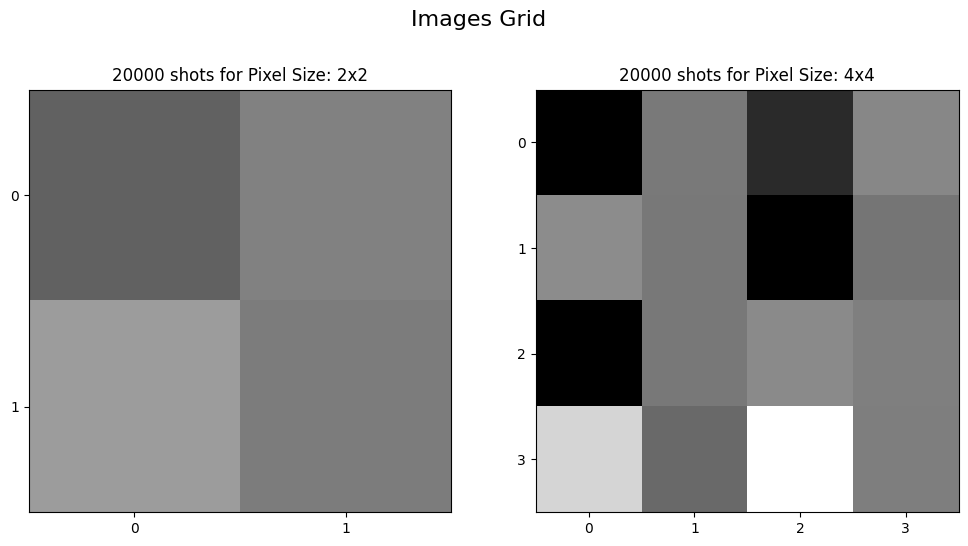

In [46]:
num_rows = 1
visualize_images_grid(num_pixels,num_rows, outputs,numOfShots)

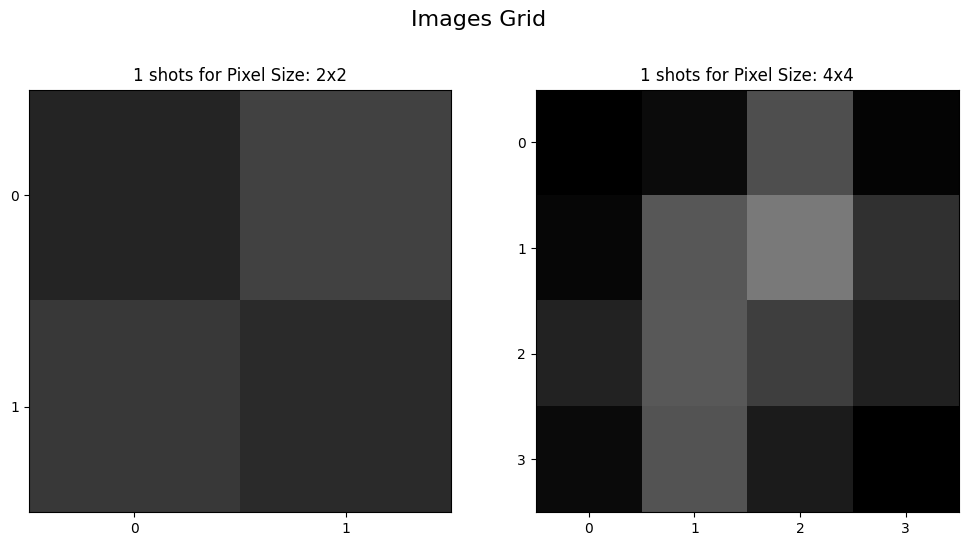

In [47]:
num_rows = 1
visualize_images_grid(num_pixels,1, input_images,1)